In [1]:
import torch
import numpy as np
import random
torch.manual_seed(1) # cpu
torch.cuda.manual_seed(1) #gpu
np.random.seed(1) #numpy
random.seed(1) #random and transforms
torch.backends.cudnn.deterministic=True # cudnn
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import cv2
import time

from config import config_dict
from datasets.generateData import generate_dataset
from net.generateNet import generate_net
import torch.optim as optim
from net.sync_batchnorm.replicate import patch_replication_callback
from torch.utils.data import DataLoader
from utils.configuration import Configuration
from utils.finalprocess import writelog
from utils.DenseCRF import dense_crf
from utils.test_utils import single_gpu_test
import os
# os.environ["CUDA_VISIBLE_DEVICES"]= "0"

/root/anaconda3/envs/ssl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = Configuration(config_dict, False)

In [3]:
cfg.TEST_CKPT = '/root/semantic-segmentation-codebase/model/deeplabv3_ddp_irn_bdcl/deeplabv3_contrast_resnet101_VOCDataset_epoch30.pth'

In [4]:
if cfg.TEST_CKPT is None:
    raise ValueError('test.py: cfg.MODEL_CKPT can not be empty in test period')

period = 'val'
dataset = generate_dataset(cfg, period=period, transform='none')
net = generate_net(cfg, batchnorm=nn.BatchNorm2d, dilated=cfg.MODEL_BACKBONE_DILATED, multi_grid=cfg.MODEL_BACKBONE_MULTIGRID, deep_base=cfg.MODEL_BACKBONE_DEEPBASE)

print('start loading model %s'%cfg.TEST_CKPT)
model_dict = torch.load(cfg.TEST_CKPT)
net.load_state_dict(model_dict,strict=False)

net.cuda()
net.eval()

/root/resnet101s-03a0f310.pth loaded.
start loading model /root/semantic-segmentation-codebase/model/deeplabv3_ddp_irn_bdcl/deeplabv3_contrast_resnet101_VOCDataset_epoch30.pth


deeplabv3_contrast(
  (backbone): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [5]:
def worker_init_fn(worker_id):
    np.random.seed(1 + worker_id)
dataloader = DataLoader(dataset, 
            batch_size=1, 
            shuffle=False, 
            num_workers=cfg.DATA_WORKERS,
            worker_init_fn = worker_init_fn)

In [6]:
def prepare_func(sample):	
    image_msf = []
    for rate in cfg.TEST_MULTISCALE:
        inputs_batched = sample['image_%f'%rate]
        image_msf.append(inputs_batched)
        if cfg.TEST_FLIP:
            image_msf.append(torch.flip(inputs_batched,[3]))
    return image_msf

def inference_func(model, img):
    outputs = model(img)
    return outputs

def collect_func(result_list, sample):
    [batch, channel, height, width] = sample['image'].size()
    for i in range(len(result_list)):
        result = F.interpolate(result_list[i], (height, width), mode='bilinear', align_corners=True)	
        if cfg.TEST_FLIP and i % 2 == 1:
            result = torch.flip(result, [3])
        result_list[i] = result
    prob = torch.cat(result_list, dim=0)
    prob = torch.mean(prob, dim=0, keepdim=True)
    prob = F.softmax(prob, dim=1)

    if cfg.TEST_CRF:
        prob = prob.detach().cpu().numpy()		
        inputs = sample['image'][0].numpy()
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        inputs[0,:,:] = (inputs[0,:,:]*std[0] + mean[0])*255
        inputs[1,:,:] = (inputs[1,:,:]*std[1] + mean[1])*255
        inputs[2,:,:] = (inputs[2,:,:]*std[2] + mean[2])*255
        inputs[inputs > 255] = 255
        inputs[inputs < 0] = 0
        img_batched = inputs.astype(np.uint8)
        prob[0] = dense_crf(prob[0], img_batched, n_classes=cfg.MODEL_NUM_CLASSES, n_iters=1)
        prob = torch.from_numpy(prob.astype(np.float32))
    result = torch.argmax(prob, dim=1).cpu().numpy().astype(np.uint8)
    result_item = result[0,:,:]
    return result_item

In [7]:
def single_gpu_test(model, dataloader, prepare_func, inference_func, collect_func):
	model.eval()
	n_gpus = torch.cuda.device_count()
	#assert n_gpus == 1
	gt_list = []
	feature_list = []
	gt_list = []
	total_num = len(dataloader)
 
	with torch.no_grad():
		for i_batch, sample in enumerate(dataloader):
			fsss_gt = sample['segmentation']
			image = sample['image']
			# result_list = []

			outputs = inference_func(net, image.cuda())	
			result, feat = outputs['pred_seg'], outputs['embed']
			print(feat.shape)
			feature_list.append(feat[0].reshape(256, -1))
   
			feat_shape = (feat.shape[2], feat.shape[3])
			fsss_gts_clone = fsss_gt.unsqueeze(1).float()
			s_fsss_gt = F.interpolate(fsss_gts_clone, feat_shape, mode='nearest').squeeze(1)
			print(s_fsss_gt.shape)
			gt_list.append(s_fsss_gt[0].reshape(-1))
			# result_item = collect_func(result_list, sample)
			# result_sample = {'predict': result_item, 'name':name[0], 'feat' : feat, }
			# result_sample = {'gt': s_fsss_gt, 'name':name[0], 'feat' : feat, }
   
			print('%d/%d'%(i_batch,total_num))
			if i_batch == 300:
				break
			# pbar.set_description('Processing')
			# pbar.update(1)
			# time.sleep(0.001)

 
	return feature_list, gt_list


In [8]:
feature_list, gt_list = single_gpu_test(net, dataloader, prepare_func=prepare_func, inference_func=inference_func, collect_func=collect_func)

torch.Size([1, 256, 46, 63])
torch.Size([1, 46, 63])
0/1449
torch.Size([1, 256, 42, 63])
torch.Size([1, 42, 63])
1/1449
torch.Size([1, 256, 42, 63])
torch.Size([1, 42, 63])
2/1449
torch.Size([1, 256, 47, 63])
torch.Size([1, 47, 63])
3/1449
torch.Size([1, 256, 63, 42])
torch.Size([1, 63, 42])
4/1449
torch.Size([1, 256, 42, 63])
torch.Size([1, 42, 63])
5/1449
torch.Size([1, 256, 47, 63])
torch.Size([1, 47, 63])
6/1449
torch.Size([1, 256, 47, 63])
torch.Size([1, 47, 63])
7/1449
torch.Size([1, 256, 42, 63])
torch.Size([1, 42, 63])
8/1449
torch.Size([1, 256, 47, 63])
torch.Size([1, 47, 63])
9/1449
torch.Size([1, 256, 47, 63])
torch.Size([1, 47, 63])
10/1449
torch.Size([1, 256, 63, 47])
torch.Size([1, 63, 47])
11/1449
torch.Size([1, 256, 42, 63])
torch.Size([1, 42, 63])
12/1449
torch.Size([1, 256, 47, 63])
torch.Size([1, 47, 63])
13/1449
torch.Size([1, 256, 47, 63])
torch.Size([1, 47, 63])
14/1449
torch.Size([1, 256, 42, 63])
torch.Size([1, 42, 63])
15/1449
torch.Size([1, 256, 29, 63])
torch

In [12]:
x = torch.cat(feature_list, dim=1).t().cpu().numpy()

In [13]:
y = torch.cat(gt_list, dim=0).cpu().numpy()

In [14]:
from sklearn.manifold import TSNE

import seaborn as sns
import pandas as pd  

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
# print(tsne.fit_transform(mask_array))
z =  tsne.fit_transform(x)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8ad3753b80>
Traceback (most recent call last):
  File "/root/anaconda3/envs/ssl/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/root/anaconda3/envs/ssl/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/root/anaconda3/envs/ssl/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/root/anaconda3/envs/ssl/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [21]:
z.shape

(850404, 2)

In [60]:
np.unique(y)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20., 255.],
      dtype=float32)

In [63]:
y_mask = y.copy()
y_mask = np.where(y_mask > 0, 1, 0)

np.unique(y_mask)

array([0, 1])

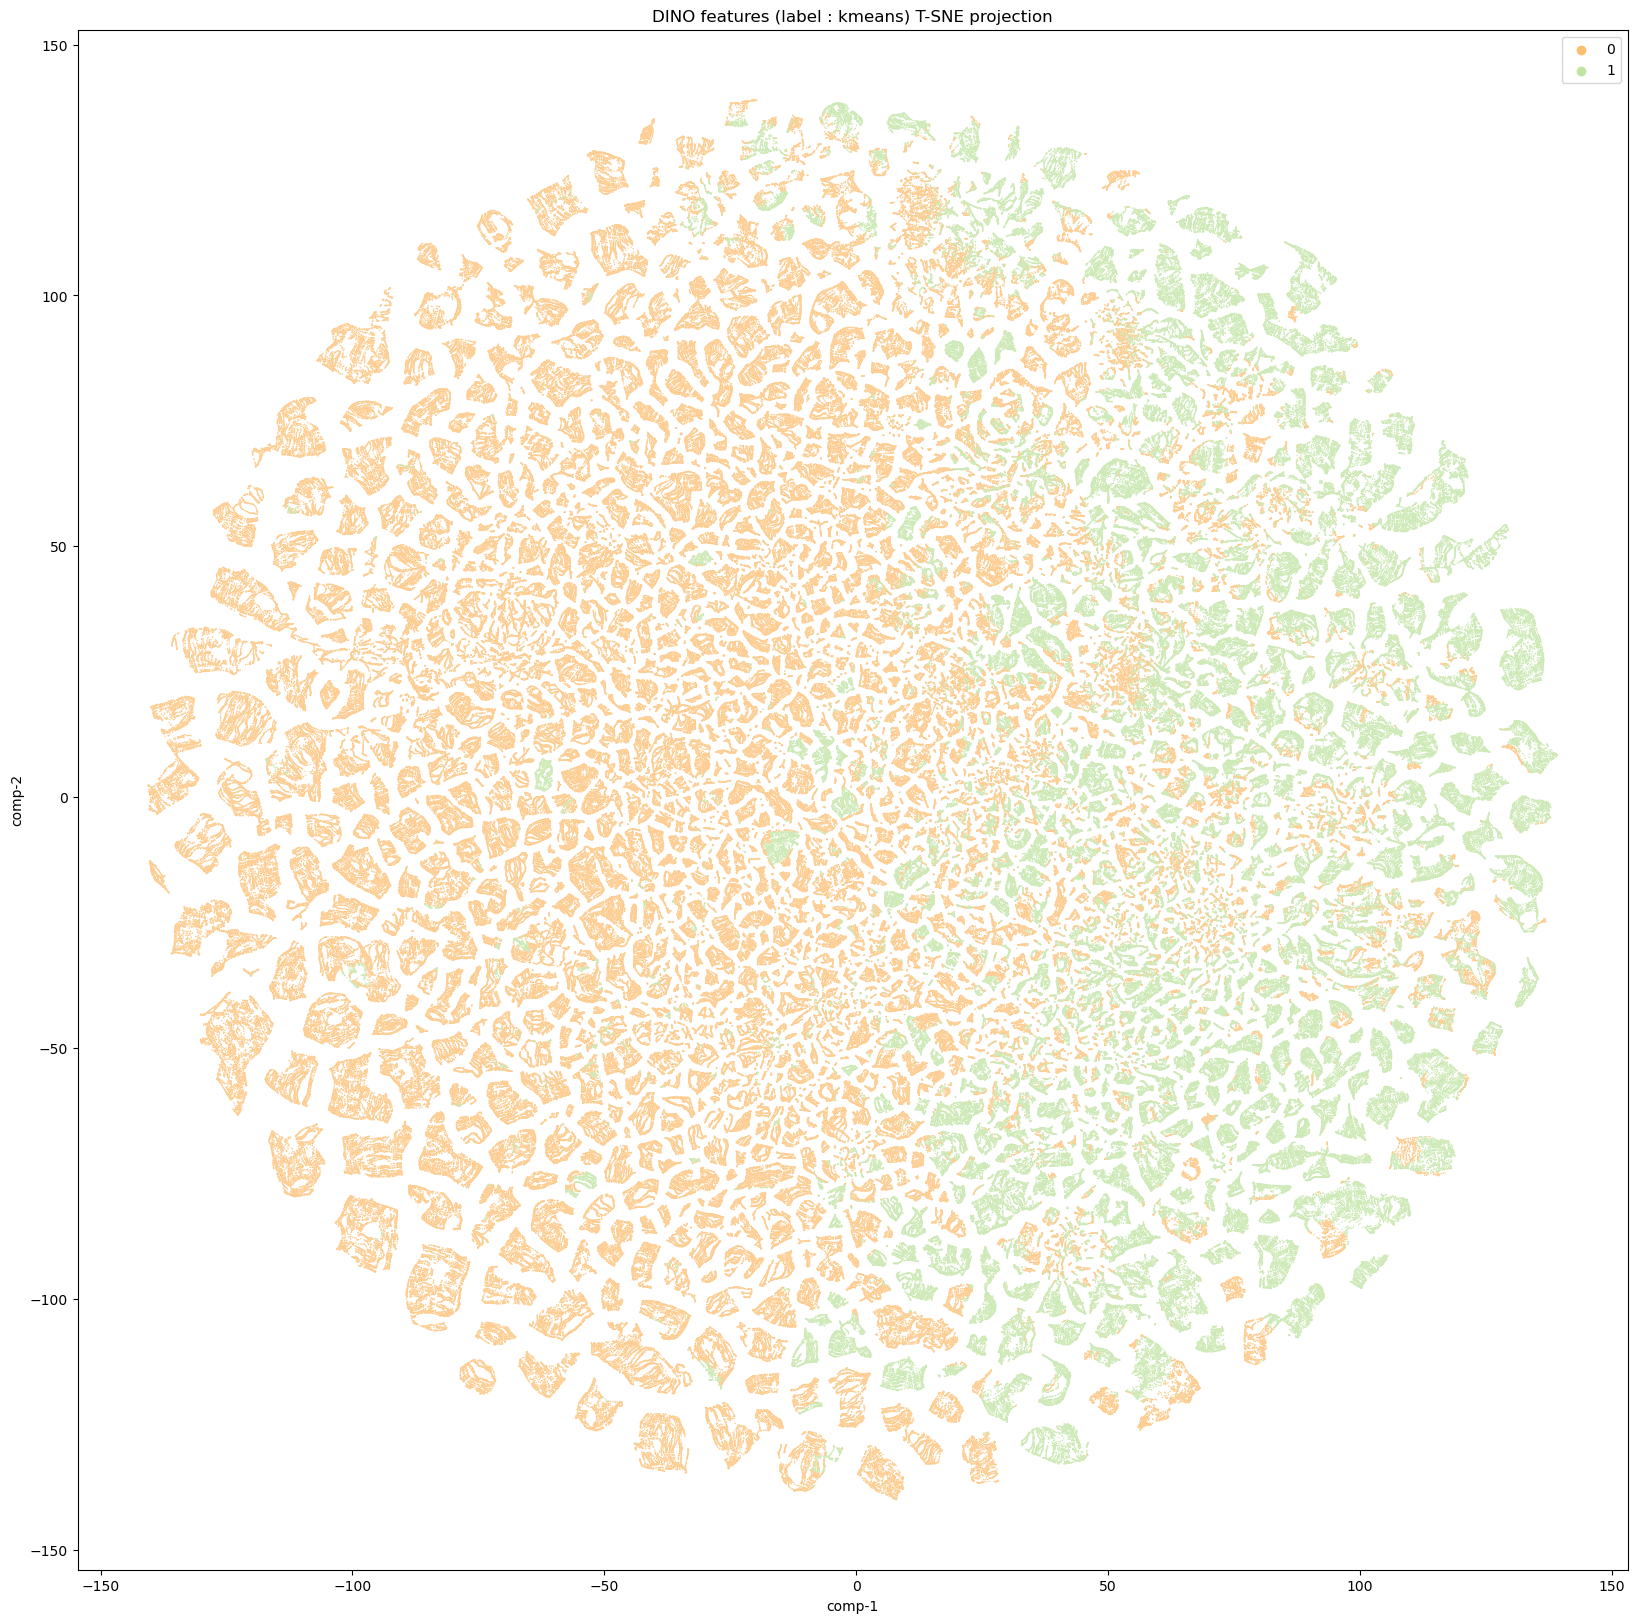

In [69]:
import matplotlib.pyplot as plt

df = pd.DataFrame()
df["y"] = y_mask
# df["y"] = k_means_labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

# sns.scatterplot(x="comp-1", y="comp-2", s = 3, hue=df.y.tolist(),
#                 palette=sns.color_palette("hls", 10),
#                 data=df).set(title="MNIST data T-SNE projection")

plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="comp-1", y="comp-2", s = 1, hue=df.y.tolist(),
                palette=sns.color_palette("Spectral", 2),
                data=df).set(title="DINO features (label : kmeans) T-SNE projection")
plt.show()

/tmp/ipykernel_419043/1078901336.py:14: UserWarning: 
The palette list has fewer values (2) than needed (22) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(x="comp-1", y="comp-2", s = 1, hue=df.y.tolist(),


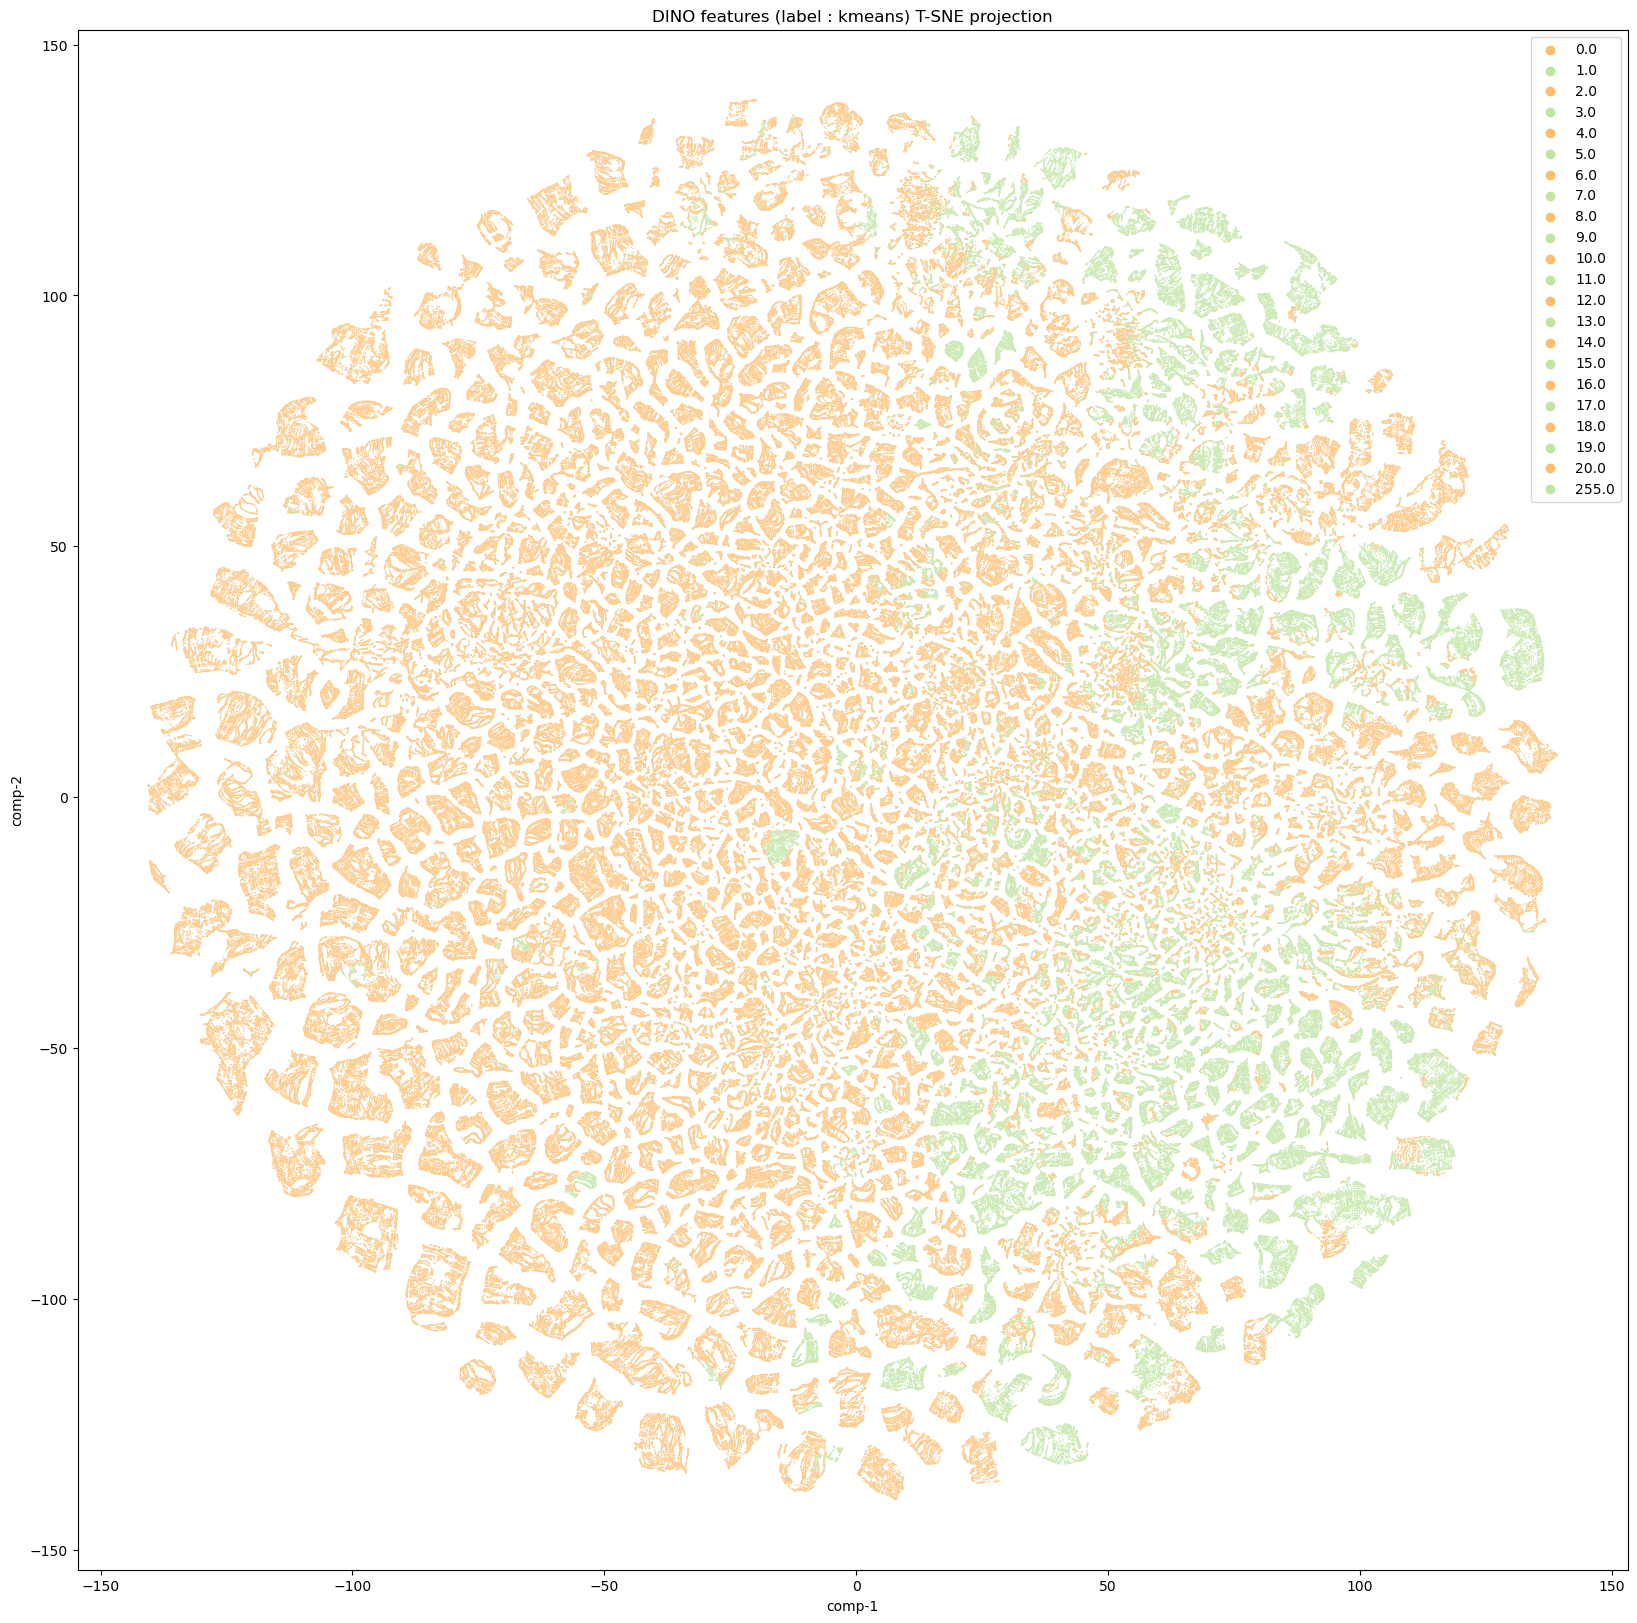

In [67]:
import matplotlib.pyplot as plt

df = pd.DataFrame()
df["y"] = y
# df["y"] = k_means_labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

# sns.scatterplot(x="comp-1", y="comp-2", s = 3, hue=df.y.tolist(),
#                 palette=sns.color_palette("hls", 10),
#                 data=df).set(title="MNIST data T-SNE projection")

plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="comp-1", y="comp-2", s = 1, hue=df.y.tolist(),
                palette=sns.color_palette("Spectral", 22),
                data=df).set(title="DINO features (label : kmeans) T-SNE projection")
plt.show()

In [66]:
sns.color_palette("Spectral", 2)

[(0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569)]

[(0.06266992646934202, 0.02711925706165498, 0.07578142666363122),
 (0.09687542262020574, 0.06678122418788301, 0.16191836629303405),
 (0.10392854711056776, 0.12195583993692868, 0.23890270624183174),
 (0.09402575835657287, 0.19049753233254862, 0.29043399570386697),
 (0.08304274423486754, 0.26594646421261964, 0.307863225277045),
 (0.08801401599773798, 0.33940630645391495, 0.2924494837317682),
 (0.12247210340662779, 0.4019851471285789, 0.2549790475326246),
 (0.2009583775206801, 0.45030085491064903, 0.20958494052721036),
 (0.30723881921584234, 0.47395920178072126, 0.18499150266658945),
 (0.4346184379049671, 0.48067890307311123, 0.19370798776056802),
 (0.5660668695319436, 0.4774304306540262, 0.24479365438842796),
 (0.6832386640154413, 0.47365800580526857, 0.3376259981801124),
 (0.7709317460324374, 0.4789939499943594, 0.4620007484160897),
 (0.8207671224550108, 0.5009271528840389, 0.6006018420312872),
 (0.8331814925220116, 0.5430012014091432, 0.7332316564779161),
 (0.814875020913895, 0.6103067986866638, 0.8499629055060692),
 (0.7855863232621401, 0.6853922006222988, 0.9192666923836995),
 (0.7624848304849502, 0.7643596735488288, 0.9508741083843375),
 (0.7605544942292889, 0.8380325492685804, 0.9531403356980039),
 (0.7881561239477163, 0.8992162030315665, 0.9418526902046614),
 (0.8447087509119424, 0.94467944965842, 0.9359266384481265),
 (0.920679414312134, 0.9761474565358058, 0.9521079986631937)]

In [65]:
sns.color_palette("husl", 2)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681)]

In [64]:
sns.color_palette("Set2", 2)

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]

In [ ]:
palette = [0,0,0,  128,0,0,  0,128,0,  128,128,0,  0,0,128,  128,0,128,  0,128,128,  128,128,128,
					 64,0,0,  192,0,0,  64,128,0,  192,128,0,  64,0,128,  192,0,128,  64,128,128,  192,128,128,
					 0,64,0,  128,64,0,  0,192,0,  128,192,0,  0,64,128,  128,64,128,  0,192,128,  128,192,128,
					 64,64,0,  192,64,0,  64,192,0, 192,192,0]

CLASSES = ('background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
           'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
           'train', 'tvmonitor')

PALETTE = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
           [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0],
           [192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128],
           [192, 0, 128], [64, 128, 128], [192, 128, 128], [0, 64, 0],
           [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]]


In [51]:
feature_list[0].shape

torch.Size([256, 2898])

In [48]:
gt_list[0].shape

torch.Size([2898])

In [34]:
for idx in range(len(gt_list)):
    

tensor([  0.,   1., 255.])

In [37]:
feature_list[0][0].reshape(256,-1).shape

torch.Size([256, 2898])

In [38]:
gt_list[0][0].reshape(-1).shape

torch.Size([2898])

In [12]:
result_list[4]['gt'].shape


torch.Size([1, 110, 73])

In [14]:
for i_batch, sample in enumerate(dataloader):
    name = sample['name']
    fsss_gt = sample['segmentation']
    image_msf = prepare_func(sample)
    break

In [18]:
sample['image'].shape

torch.Size([1, 3, 366, 500])

In [32]:
import torch
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import faiss

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

palette = [0,0,0,  128,0,0,  0,128,0,  128,128,0,  0,0,128,  128,0,128,  0,128,128,  128,128,128,
					 64,0,0,  192,0,0,  64,128,0,  192,128,0,  64,0,128,  192,0,128,  64,128,128,  192,128,128,
					 0,64,0,  128,64,0,  0,192,0,  128,192,0,  0,64,128,  128,64,128,  0,192,128,  128,192,128,
					 64,64,0,  192,64,0,  64,192,0, 192,192,0]

CLASSES = ('background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
           'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
           'train', 'tvmonitor')

PALETTE = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
           [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0],
           [192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128],
           [192, 0, 128], [64, 128, 128], [192, 128, 128], [0, 64, 0],
           [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]]


image_path = f'/root/VOCdevkit/VOC2012/JPEGImages/{file_name}.jpg'
# pseudo_label_path = f'/root/irn_pseudo_label/{file_name}.png'
gt_path = f'/root/VOCdevkit/VOC2012/SegmentationClassAug/{file_name}.png'

img = Image.open(image_path)


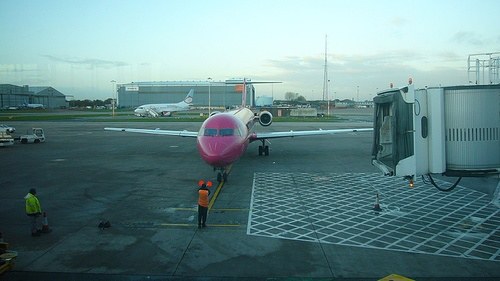

In [33]:
img

In [40]:
np.array(img).shape

(281, 500, 3)

In [45]:
image

tensor([[[ 0.1254,  0.1254,  0.1254,  ...,  0.9988,  0.9988,  0.9988],
         [ 0.1426,  0.1426,  0.1597,  ...,  1.0159,  1.0159,  0.9988],
         [ 0.1597,  0.1597,  0.1768,  ...,  1.0159,  1.0159,  0.9988],
         ...,
         [-2.0152, -2.0323, -1.9980,  ..., -1.8439, -1.8439, -1.8439],
         [-2.0323, -1.9638, -1.9124,  ..., -1.8439, -1.8268, -1.8268],
         [-2.0323, -2.0152, -1.9467,  ..., -1.8439, -1.9124, -1.8268]],

        [[ 1.3431,  1.3431,  1.3431,  ...,  2.0259,  2.0259,  2.0259],
         [ 1.3606,  1.3606,  1.3782,  ...,  2.0434,  2.0434,  2.0259],
         [ 1.3782,  1.3782,  1.3957,  ...,  2.0434,  2.0434,  2.0259],
         ...,
         [-1.7731, -1.7906, -1.8081,  ..., -1.4405, -1.4405, -1.4405],
         [-1.7906, -1.7206, -1.7381,  ..., -1.4405, -1.4230, -1.4230],
         [-1.7731, -1.7556, -1.7206,  ..., -1.4580, -1.5280, -1.4405]],

        [[ 1.8208,  1.8208,  1.8208,  ...,  2.3960,  2.3960,  2.3960],
         [ 1.8383,  1.8383,  1.8557,  ...,  2

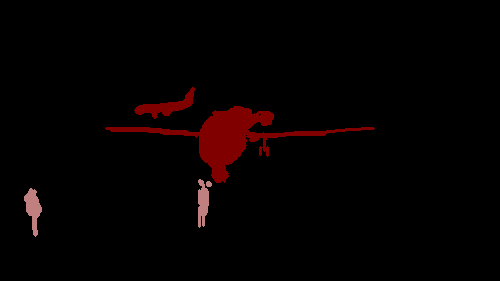

In [36]:
gt = Image.open(gt_path)
gt_np = np.array(gt)
gt_out = Image.fromarray(gt_np, mode='P')
gt_out.putpalette(palette)
gt_out

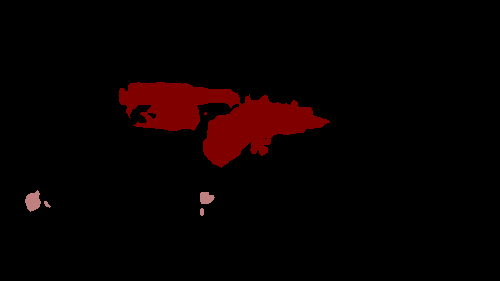

In [37]:
pseudo_label = Image.open(pseudo_label_path)
pseudo_label_np = np.array(pseudo_label)
pseudo_out = Image.fromarray(pseudo_label_np, mode='P')
pseudo_out.putpalette(palette)
pseudo_out

In [38]:
pseudo_label_np.shape

(281, 500)